# ***EE7204 Assignment 02***
<body>EG/2018/3335 - Gunawardhana S.D.H.C.</body>

***1. Consider an image with 2 objects and a total of 3-pixel values (1 for each object and one for the background). Add Gaussian noise to the image. Implement and test Otsu’s algorithm with this image.***

Creating the original greyscale image and the image with gaussian noise

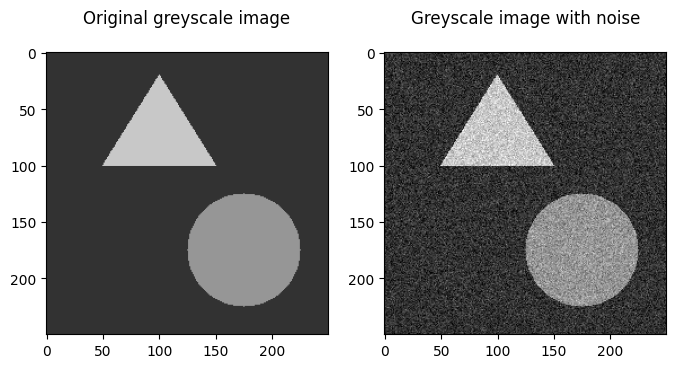

In [1]:
import numpy as np
import cv2
from queue import Queue
import matplotlib.pyplot as plt

# Creating a black image of size 250 x 250
img_original = np.zeros((250, 250), dtype=np.uint8)

# Drawing a filled triangle with pixel value of 200
triangle_points = np.array([[50, 100], [100, 20], [150, 100]])
cv2.fillPoly(img_original, [triangle_points], color=200)

# Drawing a filled circle with pixel value of 150
cv2.circle(img_original, (175, 175), 50, color=150, thickness=-1)

# Setting the background to pixel value 50
img_original[img_original == 0] = 50

# Creating the image with gaussian noise (mean = 0, sigma, shape of the image)
gaussian = np.random.normal(0, np.sqrt(500), img_original.shape)
img_noise = gaussian + img_original
img_noise = np.clip(img_noise, 0, 255)

# Creating a figure with two subplots and display original image and the image with gaussian noise
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(img_original, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Original greyscale image\n")

axs[1].imshow(img_noise, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Greyscale image with noise\n")

plt.show()

Implementing and testing Otsu’s algorithm with noisy image.

Threshold value obtained using Otsu s algorithm = 109


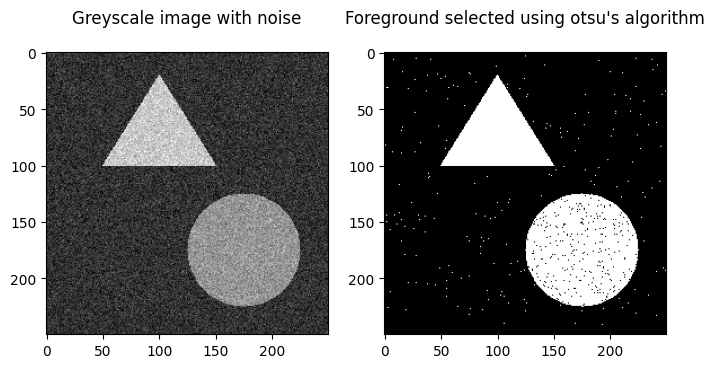

In [2]:
# Computing histogram of image
histogram, bin_edges = np.histogram(img_noise, bins=256, range=(0, 255))

# Computing probability mass function of image
prob = histogram / float(np.sum(histogram))

# Initializing variables
best_threshold = 0
best_variance = 0
total_mean = np.mean(img_noise)

# Iterating over all possible threshold values
for t in range(int(np.min(img_noise)), int(np.max(img_noise)) + 1):
    # Computing sum of probabilities of foreground and background classes seperated by t
    prob_f = np.sum(prob[:t])
    prob_b = np.sum(prob[t:])

    # Skipping the iteration if probabilities are empty
    if prob_f == 0 or prob_b == 0:
        continue

    # Computing means of foreground and background classes
    mean_f = np.sum(prob[:t] * np.arange(t)) / prob_f
    mean_b = np.sum(prob[t:] * np.arange(t, 256)) / prob_b

    # Computing variance between foreground and background classes
    variance = prob_f * prob_b * (mean_f - mean_b) ** 2

    # Updating best threshold and variance if the variance is grater than current variance
    if variance > best_variance:
        best_threshold = t
        best_variance = variance

print(f'Threshold value obtained using Otsu s algorithm = {best_threshold}')
output = cv2.threshold(img_noise, best_threshold, 255, cv2.THRESH_BINARY)[1]

# Creating a figure with two subplots representig noisy image and foreground selected
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(img_noise, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Greyscale image with noise\n")

axs[1].imshow(output, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Foreground selected using otsu's algorithm\n")

plt.show()

* Comments: Otsu's algorithm calculates the best threshold value which gives the maximum variance in classification without any user input. The foreground objects were selected with good accuracy even with the noise in the source image. But there are small artifacts in the image. The artifacts of the resultant image foreground can be filtered by performing dialation first and erotion next. The artifacts of the resultant image background can be filtered by performing erosion first and dialation next.

***2. Implement a region-growing technique for image segmentation. The basic idea is to start from a set of points inside the object of interest (foreground), denoted as seeds, and recursively add neighboring pixels as long as they are in a pre-defined range of the pixel values of the seeds.***

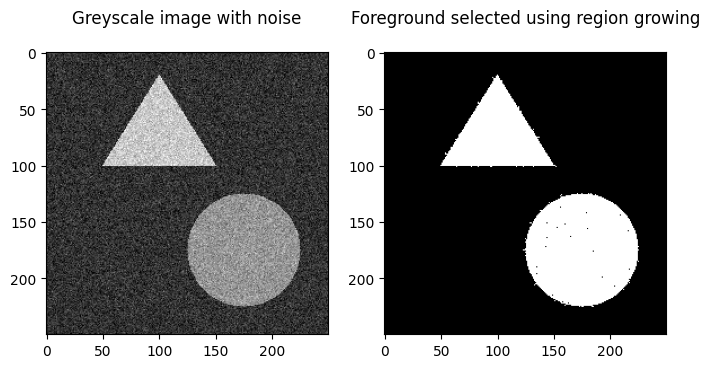

In [3]:
# Defining the range of pixel values for region growing
pixel_range = 50

# Defining the seeds as x, y coordinates (one seed for each object)
seeds = [(100, 55), (180, 150)] # [triangle, circle]

# Creating a binary mask to store the segmentation result
mask = np.zeros([250,250])

# Defining a function to check if the given pixel value is within the range of seeds
def check_range(pixel):
    for seed in seeds:
        if abs(img_noise[pixel] - img_noise[seed]) <= pixel_range:
            return True
    return False

# Region growing for all seeds
for seed in seeds:
    # Queue data structure was used to store the pixels to be visited
    pix_queue = Queue()
    pix_queue.put(seed)

    # Iterating until the queue is empty
    while not pix_queue.empty():
        pixel = pix_queue.get()

        # Checking if the current pixel value is within the range of seeds
        if mask[pixel] == 0 and check_range(pixel):
            # If yes, selecting that pixel to foreground
            mask[pixel] = 1

            # Getting the 8 neighbour pixels to the current pixel
            x, y = pixel
            neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)]

            # Checking whether the neighbours calculated are within the image and then adding them to the queue
            for neighbor in neighbors:
                if (0 <= neighbor[0] < img_noise.shape[0] and 0 <= neighbor[1] < img_noise.shape[1]):
                    pix_queue.put(neighbor)

# Creating a figure with two subplots representig noisy image and foreground selected
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(img_noise, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Greyscale image with noise\n")

axs[1].imshow(mask, cmap='gray', vmin=0, vmax=1)
axs[1].set_title("Foreground selected using region growing\n")

plt.show()


* Comments: Compared to the Otsu's algorithm, region growing resulted in very good selection with less artifacts for this image. But, seeds and range should be provided to the region growing as a input where Otsu's algorithm doesn't required any input. The artifacts of the resultant image foreground can be filtered by performing dialation first and erotion next. The accuracy of two algorithms for an image can be varied depend on the nature of the image.